In [3]:
import os
import random

from argparse import Namespace

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import cv2 as cv
from PIL import Image

import wandb
from wandb.sdk.wandb_run import Run
from kaggle_secrets import UserSecretsClient

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils import data as ds
from torch.optim.sgd import SGD

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.ops import nms

In [4]:
config = Namespace(
    seed=4,
    project_name="car-object-detection-training",

    train_manifest_path="/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv",
    train_base_img_path="/kaggle/input/car-object-detection/data/training_images",

    n_classes=2,
    img_dims=(224, 224),

    n_epochs=30,
    test_size=0.2,
    batch_size=4,
    lr=0.005,
    patience=8,
    model_name="faster-r-cnn-v1.1.pt",
    
    device="cpu",
    #device="cuda",
)

# enable reproduceability
os.environ["PYTHONHASHSEED"] = str(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

if config.device == "cuda":
    torch.cuda.manual_seed_all(config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# setup wandb login to observe progress
user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: soap4chkns to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# image -> bounding box coordinates
# NOTE: images may contain multiple boxes
train_manifest_df = pd.read_csv(config.train_manifest_path)
train_manifest_df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [7]:
# split up the data according to the image files. since there's potentially multiple bounding boxes per image
# this should be split according to the image id
train_ids, val_ids = train_test_split(
    train_manifest_df["image"].unique().tolist(),
    test_size=config.test_size,
    random_state=config.seed
)

train_df = train_manifest_df[train_manifest_df["image"].isin(train_ids)]
cv_df = train_manifest_df[train_manifest_df["image"].isin(val_ids)]

assert len(train_df) + len(cv_df) == len(train_manifest_df), f"Data split mismatch {len(train_df)} + {len(cv_df)} /= {len(train_manifest_df)}"

print(f"Train Size: {len(train_df)}")
print(f"Cross validation size: {len(cv_df)}")

Train Size: 451
Cross validation size: 108


In [8]:
class CarDetectionDataset(ds.Dataset):

    def __init__(self, df: pd.DataFrame, img_dir: str, img_dims: tuple[int, int], img_mapping: list[str]):
        self.df = df
        self.img_dir = img_dir
        self.img_dims = img_dims
        self.img_mapping = img_mapping

    def __getitem__(self, i: int) -> tuple[torch.Tensor, dict[str, torch.Tensor]]:

        # load image and corresponding bounding boxes
        filename = self.img_mapping[i]
        img_path = os.path.join(config.train_base_img_path, filename)
        img = Image.open(img_path).convert("RGB")
        boxes = self.df[self.df["image"] == filename]
        h, w, _ = np.array(img).shape

        # normalize the dimension of the bounding boxes
        boxes.loc[:, ["xmin", "ymin", "xmax", "ymax"]] /= [w, h, w, h]

        # normalize the value of the images from 0 to 1
        img = np.array(img.resize(self.img_dims, resample=Image.BILINEAR)) / 255.
        labels = torch.ones(len(boxes)).long()
        boxes = boxes[["xmin", "ymin", "xmax", "ymax"]].values

        # regenerate the dimension of the bounding boxes of the new size
        boxes[:, [0,2]] *= self.img_dims[0]
        boxes[:, [1,3]] *= self.img_dims[1]
        boxes = boxes.astype(np.uint32).tolist()

        # for each img, create boxes and corresponding label
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = labels

        # preprocess img
        img = torch.tensor(img).permute(2, 0, 1)
        img = img.to(config.device).float()
        
        return img, target

    def __len__(self) -> int:
        return len(self.img_mapping)

def collate_fn(batch: torch.Tensor) -> tuple[torch.Tensor, list[dict[str, torch.Tensor]]]:
    imgs, targets = zip(*batch)
    imgs = [img.to(config.device) for img in imgs]
    targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]
    return imgs, targets

def build_loader(df: pd.DataFrame) -> ds.DataLoader:
    loader = ds.DataLoader(
        CarDetectionDataset(
            df=df,
            img_dir=config.train_base_img_path,
            img_dims=config.img_dims,
            img_mapping=df["image"].unique().tolist()
        ),
        batch_size=config.batch_size,
        collate_fn=collate_fn,
        drop_last=True,
    )
    return loader

train_loader = build_loader(train_df)
cv_loader = build_loader(cv_df)

In [9]:
# establish a pretrained, light version of the fast rcnn resnet 50 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, config.n_classes)
model = model.to(config.device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=config.lr,
    momentum=0.9,
    weight_decay=0.0005,
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]  


In [21]:
# initial values prior to training loop
best_valid_loss = float("inf")
patience_counter = 0

def inference(imgs: list[torch.Tensor], targets: list[dict[str, torch.Tensor]], inference_type: str, model: FasterRCNN, wandb_run: Run) -> torch.Tensor:
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    run.log({
        f"{inference_type}-loss": loss,
        f"{inference_type}-location-loss": losses["loss_classifier"],
        f"{inference_type}-regr-loss": losses["loss_box_reg"],
        f"{inference_type}-objectness-loss": losses["loss_objectness"],
        f"{inference_type}-rpn-box-reg-loss": losses["loss_rpn_box_reg"],
    })
    return loss

# track the specific experiment over wandb
wandb_config = {
    "learning_rate": config.lr,
    "momentum": 0.9,
    "weight-decay": 0.0005,
    "epochs": config.n_epochs,
    "seed": config.seed,
    "validation-size": config.test_size,
    "batch-size": config.batch_size,
    "img-dims": config.img_dims,
    "patience": config.patience,
}

with wandb.init(
    project=config.project_name, 
    name="baseline_experiment_1.5", 
    config=wandb_config
) as run:

    for epoch in range(config.n_epochs):

        print(f"Epoch: {epoch+1}/{config.n_epochs}")

        # training loop
        for i, (imgs, targets) in (pbar := tqdm(enumerate(train_loader))):

            model.train()
            optimizer.zero_grad()
            loss = inference(imgs, targets, "train", model, run)
            pbar.set_description(f"loss: {loss:.4f}")
        
            loss.backward()
            optimizer.step()

        # cross validation loop
        for i, (imgs, targets) in (pbar := tqdm(enumerate(cv_loader))):
            model.train()
            optimizer.zero_grad()

            loss = inference(imgs, targets, "validation", model, run)
            if loss < best_valid_loss:
                best_valid_loss = loss
                torch.save(model.state_dict(), config.model_name)
                run.log_model(
                    path=config.model_name,
                    name=config.model_name,
                    aliases=["best"]
                )
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= config.patience:
                print(f"Early stopping following patience setting: {config.patience}")
                break

# log the model external to the notebook so that we can pull it later,without
# the need of a gpu environment
model.load_state_dict(torch.load(config.model_name))

Epoch: 1/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 3/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 4/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 5/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 6/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 7/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 8/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 9/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 10/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 11/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 12/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 13/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 14/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 15/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 16/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 17/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 18/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 19/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 20/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 21/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 22/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 23/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 24/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 25/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 26/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 27/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 28/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 29/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8
Epoch: 30/30


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping following patience setting: 8


train-location-loss,▁▄▃▂▇▂▂▂▃▂█▂▂▃▂▂▄▁▁▂▁▂▁▃▂▆▁▁▄▁▂▂▁▁▁▁▃▂▃▂
train-loss,▄▄▂▃▄▆▅▃▂▃█▁▄▅▅▁▂▆▂▂▃▃▂▂▄▁▃▃▂▁▄▁▃▂▃▂▁▄▁▂
train-objectness-loss,▆█▂▂▇▁▂▁▅▁▆▂▃▂▃▃▂▃▂▆▁▄▂▅▃▃▆▂▂▄▁▆▂▂▃▂▅▅▁▃
train-regr-loss,▆▄▃▂▂▅▁▄▅▃▂▄▄▁▂▄▃▃▂▁▁▁▁▂▆▃▁▁▅▁▂▃▂▂▃█▃▁▂▁
train-rpn-box-reg-loss,▇▇█▂▇▂▂▃▇▃▅▂▄▂▄▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▃▂▃▂▂▃
validation-location-loss,▁▂▇▂▃▃▃█▂▁▃▁▂▆▅▂▂▂▂▂▂▃▁▂▂▁▁▁▁▂▁▄▆▇▄▅▃▂▅▂
validation-loss,▂▂▅▅▃▂▃█▄▁▄▃▂▅▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▃▆▁▃▂▂▂▁
validation-objectness-loss,▁▅▁▁▁▁▁▁▂▁▁▁▁▄▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▁▁▁▁▁▁▁
validation-regr-loss,▂▅▅▃▁▂▂▃█▃▁▄▃▂▂▄▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▅▁▂▂▂▁
validation-rpn-box-reg-loss,▁▁▄█▃▂▅▇▃▂▄▁▂▄█▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▃▅▁▁▁▁▄▃▁
train-location-loss,0.00457


<All keys matched successfully>

In [10]:
# if no training has happened, load the latest model from wandb
with wandb.init() as run:
    model_path = run.use_model(name="soap4chkns/car-object-detection-training/faster-r-cnn-v1.1.pt:v1")
    model.load_state_dict(torch.load(model_path, map_location=config.device))

wandb: Downloading large artifact faster-r-cnn-v1.1.pt:v1, 158.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:7.1


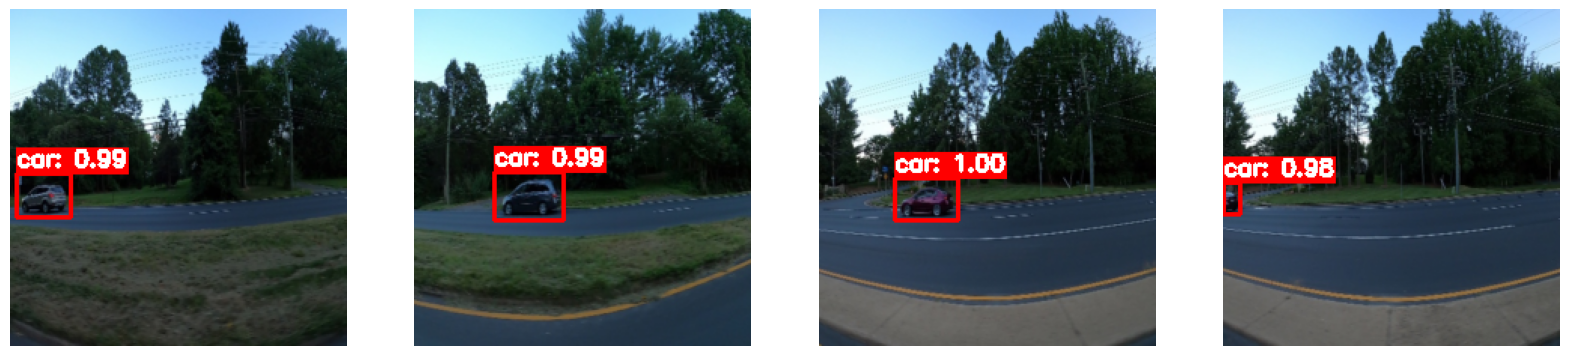

In [22]:
# test what model output / bounding boxes currently look like
def dec_output(output: torch.Tensor):

    # unpack model inference
    bbs = output["boxes"].cpu().detach().numpy().astype(np.uint16)
    # we know 0 is background and 1 is car, by default
    labels = np.array(["car" if i == 1 else "bg" for i in output["labels"].cpu().detach().numpy()])
    confs = output["scores"].cpu().detach().numpy()

    # TODO: why 0.05?
    ids = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ids] for tensor in [bbs, confs, labels]]
    if len(ids) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
        
    return bbs.tolist(), confs.tolist(), labels.tolist()

#  given an image with some outputs, draw bounding boxes around instances where the car is detected
def plot_bbs_confs_labels(image: np.array, bbs: list[np.array], confs: list[np.array], labels: list[str], label_colors: dict[str, tuple[int, int, int]]) -> np.array:

    img_bbs = image.copy()
    for bb, conf, label in zip(bbs, confs, labels):
        x, y, w, h = bb
        # default to green
        color = label_colors.get(label, (0, 255, 0))

        # draw bounding box
        cv.rectangle(img_bbs, (x, y), (w, h), color, 2)

        # prepare label text
        text = f"{label}: {conf:.2f}"
        (text_width, text_height), baseline = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv.rectangle(img_bbs, (x, y), (x + text_width, y - text_height - baseline), color, cv.FILLED)
        cv.putText(img_bbs, text, (x, y - baseline), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return img_bbs

# select the first sample from the cross-validation loader and test model inference
# move the model out of training mode to prepare for inference
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
ax = ax.flatten()

imgs, targets = next(iter(cv_loader))

model.eval()
outputs = model(imgs)
for i, output in enumerate(outputs):

    bbs, confs, labels = dec_output(output)
    img_with_bbs = plot_bbs_confs_labels(
        image=imgs[i].cpu().permute(1,2,0).numpy(),
        bbs=bbs,
        confs=confs,
        labels=labels,
        label_colors={"car": (255,0,0)},
    )
    # display the image with bounding boxes
    ax[i].imshow(img_with_bbs)
    ax[i].axis("off")